# Compiled Autograd: Capturing a larger backward graph for torch.compile

# Overview
Compiled Autograd is a torch.compile extension introduced in PyTorch 2.4 that allows the capture of a larger backward graph.

While torch.compile does capture the backward graph, it does so partially. The AOTAutograd component captures the backward graph ahead-of-time, with certain limitations:

Graph breaks in the forward lead to graph breaks in the backward

Backward hooks are not captured

Compiled Autograd addresses these limitations by directly integrating with the autograd engine, allowing it to capture the full backward graph at runtime. Models with these two characteristics should try Compiled Autograd, and potentially observe better performance.

However, Compiled Autograd introduces its own limitations:

Added runtime overhead at the start of the backward for cache lookup

More prone to recompiles and graph breaks in dynamo due to the larger capture

Note

Compiled Autograd is under active development and is not yet compatible with all existing PyTorch features. For the latest status on a particular feature, refer to Compiled Autograd Landing Page.

# Setup
In this tutorial, we will base our examples on this simple neural network model. It takes a 10-dimensional input vector, processes it through a single linear layer, and outputs another 10-dimensional vector.

In [1]:
%%writefile example.py
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(10, 10)

    def forward(self, x):
        return self.linear(x)

model = Model()
x = torch.randn(10)

torch._dynamo.config.compiled_autograd = True

@torch.compile
def train(model, x):
    loss = model(x).sum()
    loss.backward()

train(model, x)

Overwriting example.py


In [2]:
import torch

class Model(torch.nn.Module):
   def __init__(self):
      super().__init__()
      self.linear = torch.nn.Linear(10, 10)

   def forward(self, x):
      return self.linear(x)

 # Basic usage
Before calling the torch.compile API, make sure to set torch._dynamo.config.compiled_autograd to True:

In [3]:
model = Model()
x = torch.randn(10)

torch._dynamo.config.compiled_autograd = True
@torch.compile
def train(model, x):
   loss = model(x).sum()
   loss.backward()

train(model, x)

In the code above, we create an instance of the Model class and generate a random 10-dimensional tensor x by using torch.randn(10). We define the training loop function train and decorate it with @torch.compile to optimize its execution. When train(model, x) is called:

    Python Interpreter calls Dynamo, since this call was decorated with @torch.compile.

    Dynamo intercepts the Python bytecode, simulates their execution and records the operations into a graph.

    AOTDispatcher disables hooks and calls the autograd engine to compute gradients for model.linear.weight and model.linear.bias, and records the operations into a graph. Using torch.autograd.Function, AOTDispatcher rewrites the forward and backward implementation of train.

    Inductor generates a function corresponding to an optimized implementation of the AOTDispatcher forward and backward.

    Dynamo sets the optimized function to be evaluated next by Python Interpreter.

    Python Interpreter executes the optimized function, which executes loss = model(x).sum().

    Python Interpreter executes loss.backward(), calling into the autograd engine, which routes to the Compiled Autograd engine since we set torch._dynamo.config.compiled_autograd = True.

    Compiled Autograd computes the gradients for model.linear.weight and model.linear.bias, and records the operations into a graph, including any hooks it encounters. During this process, it will record the backward previously rewritten by AOTDispatcher. Compiled Autograd then generates a new function which corresponds to a fully-traced implementation of loss.backward(), and executes it with torch.compile in inference mode.

    The same steps recursively apply to the Compiled Autograd graph, but this time AOTDispatcher will not need to partition the graph.

# Inspecting the compiled autograd logs
Run the script with the TORCH_LOGS environment variables:

To only print the compiled autograd graph, use TORCH_LOGS="compiled_autograd" python example.py

To print the graph with more tensor metadata and recompile reasons, at the cost of performance, use TORCH_LOGS="compiled_autograd_verbose" python example.py

Rerun the snippet above, the compiled autograd graph should now be logged to stderr. Certain graph nodes will have names that are prefixed by aot0_, these correspond to the nodes previously compiled ahead of time in AOTAutograd backward graph 0, for example, aot0_view_2 corresponds to view_2 of the AOT backward graph with id=0.

In the image below, the red box encapsulates the AOT backward graph that is captured by torch.compile without Compiled Autograd.

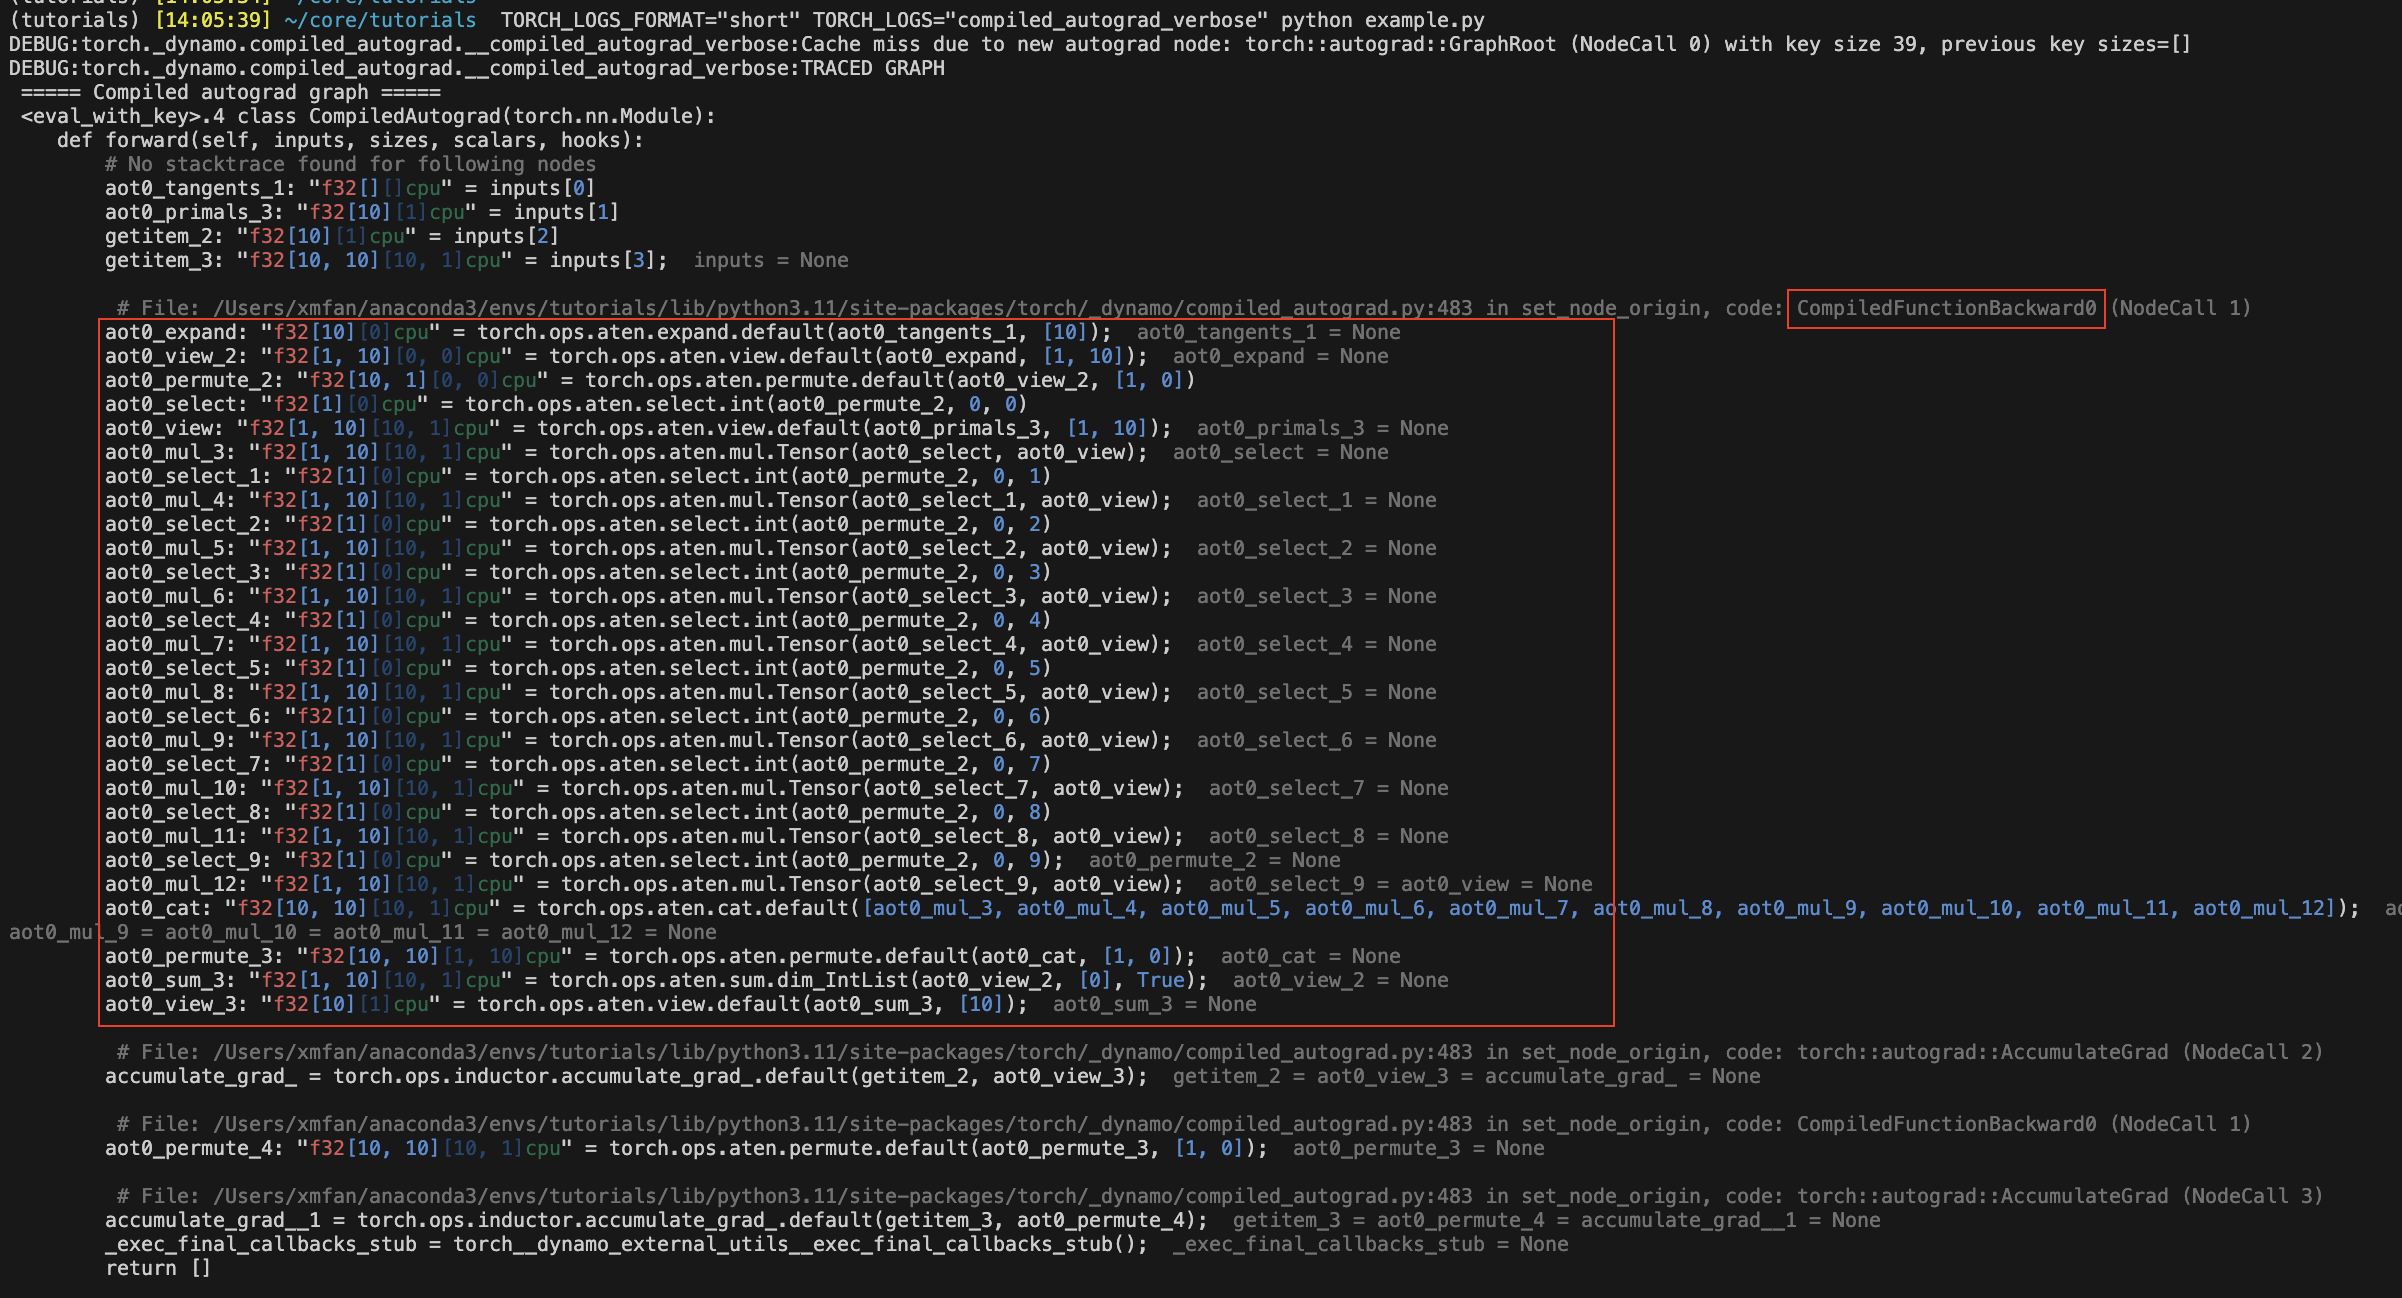

This is the graph on which we will call torch.compile, NOT the optimized graph. Compiled Autograd essentially generates some unoptimized Python code to represent the entire C++ autograd execution.

# Compiling the forward and backward pass using different flags
You can use different compiler configs for the two compilations, for example, the backward may be a fullgraph even if there are graph breaks in the forward.

In [4]:
%%writefile example.py
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(10, 10)

    def forward(self, x):
        return self.linear(x)

model = Model()
x = torch.randn(10)

torch._dynamo.config.compiled_autograd = True

@torch.compile
def train(model, x):
    model = torch.compile(model)
    loss = model(x).sum()
    torch._dynamo.config.compiled_autograd = True
    torch.compile(lambda: loss.backward(), fullgraph=True)()

train(model, x)



Overwriting example.py


Or you can use the context manager, which will apply to all autograd calls within its scope.

In [5]:
def train(model, x):
   model = torch.compile(model)
   loss = model(x).sum()
   with torch._dynamo.compiled_autograd.enable(torch.compile(fullgraph=True)):
      loss.backward()

# Compiled Autograd addresses certain limitations of AOTAutograd
Graph breaks in the forward pass no longer necessarily lead to graph breaks in the backward pass:

In [7]:
print(torch.__version__)


2.8.0


In [8]:
import torch._dynamo as dynamo

print(hasattr(dynamo, 'compiled_autograd'))

True


In [9]:
import torch._dynamo.compiled_autograd as ca
print(dir(ca))



['AutogradCompilerInstance', 'AutogradLazyBackwardCompileInfo', 'BackwardState', 'COMPILE_COUNTER', 'CachedAutogradLazyBackwardCompileInfo', 'CapturedTraceback', 'CompileContext', 'CompileId', 'Counter', 'DimDynamic', 'FakeCompiledAutogradEngine', 'FakeTensorMode', 'GetItemSource', 'GraphModule', 'LocalSource', 'NaNChecker', 'Op', 'OpNamespace', 'Optional', 'OrderedSet', 'ProxyTorchDispatchMode', 'PythonKeyTracer', 'ShapeEnv', 'TURN_OFF_MSG', 'TYPE_CHECKING', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_disable', '_enable', '_graph_placeholders', '_impure_targets', 'active_disable_ctx', 'call_accumulate_grad', 'call_backward', 'call_hook', 'clone_preserve_strides', 'compile_context', 'compiled_autograd_enabled', 'compiled_autograd_enabled_force_eager', 'compiled_autograd_log', 'contextlib', 'copy_slices_epilogue', 'copy_slices_prologue', 'counters', 'decompose', 'defaultdict', 'depth', 'disable_autocast_cache', 'di

In [10]:
torch._dynamo.config.compiled_autograd = True


In [11]:
#no need for compiled_autograd.enable(...) anymore

@torch.compile(backend="aot_eager")
def fn(x):
    temp = x + 10
    torch._dynamo.graph_break()
    temp = temp + 10
    torch._dynamo.graph_break()
    return temp.sum()

x = torch.randn(10, 10, requires_grad=True)
torch._dynamo.utils.counters.clear()

loss = fn(x)
loss.backward()

print("Graphs compiled:", torch._dynamo.utils.counters["stats"]["unique_graphs"])


Graphs compiled: 3


In [6]:
@torch.compile(backend="aot_eager")
def fn(x):
   # 1st graph
   temp = x + 10
   torch._dynamo.graph_break()
   # 2nd graph
   temp = temp + 10
   torch._dynamo.graph_break()
   # 3rd graph
   return temp.sum()

x = torch.randn(10, 10, requires_grad=True)
torch._dynamo.utils.counters.clear()
loss = fn(x)

# 1. base torch.compile
loss.backward(retain_graph=True)
assert(torch._dynamo.utils.counters["stats"]["unique_graphs"] == 3)
torch._dynamo.utils.counters.clear()

# 2. torch.compile with compiled autograd
with torch._dynamo.compiled_autograd.enable(torch.compile(backend="aot_eager")):
   loss.backward()

# single graph for the backward
assert(torch._dynamo.utils.counters["stats"]["unique_graphs"] == 1)

AttributeError: module 'torch._dynamo.compiled_autograd' has no attribute 'enable'

In the first torch.compile case, we see that 3 backward graphs were produced due to the 2 graph breaks in the compiled function fn. Whereas in the second torch.compile with compiled autograd case, we see that a full backward graph was traced despite the graph breaks.

Note

It is still possible for the Dynamo to graph break when tracing backward hooks captured by Compiled Autograd.

Backward hooks can now be captured

In [12]:
@torch.compile(backend="aot_eager")
def fn(x):
   return x.sum()

x = torch.randn(10, 10, requires_grad=True)
x.register_hook(lambda grad: grad+10)
loss = fn(x)

with torch._dynamo.compiled_autograd.enable(torch.compile(backend="aot_eager")):
   loss.backward()

AttributeError: module 'torch._dynamo.compiled_autograd' has no attribute 'enable'

In [13]:
@torch.compile(backend="aot_eager")
def fn(x):
    return x.sum()

x = torch.randn(10, 10, requires_grad=True)

# Add a hook
x.register_hook(lambda grad: grad + 10)

# Run forward + backward
loss = fn(x)
loss.backward()

# Common recompilation reasons for Compiled Autograd

Due to changes in the autograd structure of the loss value:
Due to tensors changing shapes:
